In [231]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("../include/")
import hhtools
import hhsignal

import importlib
from tqdm.notebook import tqdm
importlib.reload(hhtools)

<module 'hhtools' from '/home/jungyoung/Project/hh_neuralnet/three_pop_mpi/../include/hhtools.py'>

In [232]:
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.facecolor"] = "w"

# Check summary 

## Concat simulations

# Full summary 

In [3]:
obj = hhtools.SummaryLoader("./asym_link_full/")
print(obj.summary["chi"].shape)
print(obj.controls.keys())

# correction
obj.summary["chi"][:,:,:,:,24:48,0] = np.nan

(15, 15, 2, 7, 72, 3)
dict_keys(['alpha_set', 'beta_set', 'id_rank', 'p_ratio_set'])


# Single sample test

In [ ]:
data = obj.load_detail(5, 1, 1, 5, 1)

In [ ]:
importlib.reload(hhsignal)

data = obj.load_detail(13, 0, 1, 2, 0)
# data = obj.load_detail(2, 6, 1, 5, 0)

t0 = 2
wbin_t = 1
idt = (data["ts"] >= t0) & (data["ts"] < t0+wbin_t)

cc, tlag = hhsignal.get_correlation(data["vlfp"][1][idt], data["vlfp"][1][idt], 2000, max_lag=0.1)
idp = hhsignal.find_corr_peaks(cc)

plt.figure(figsize=(3, 2))
plt.plot(tlag, cc, 'k')
plt.plot(tlag[idp], cc[idp], 'rp')
print(tlag[idp][1:] * 1e3, cc[idp])
plt.show()

# Summary 

In [33]:
obj = hhtools.SummaryLoader("./asym_link_full/")
print(obj.summary["chi"].shape)
print(obj.controls.keys())

# correction
# obj.summary["chi"][:,:,:,:,24:48,0] = np.nan
obj.summary["chi"][obj.summary["chi"] > 1] = np.nan

import pickle as pkl
with open("./asym_link_full_out.pkl", "rb") as fp:
    order_dyna = pkl.load(fp)
print(order_dyna.keys())

(15, 15, 2, 7, 72, 3)
dict_keys(['alpha_set', 'beta_set', 'id_rank', 'p_ratio_set'])
dict_keys(['ac2p_large', 'ac2p_1st', 'fpeak', 'ac2t_large', 'ac2t_1st', 'cc1p_large', 'cc1t_large', 'prefix'])


In [7]:
def draw_orders(im_set, x=None, y=None, xt=None, yt=None, axs=None, clim=None, alpha_map=None, ftitle=None, title_fontsize=None):
    if alpha_map is None:
        alpha_map = [None, None, None]
    
    pallete = []
    for n in range(3):
        if axs is None:
            plt.subplot(1,3,n+1)
        else:
            plt.axes(axs[n])
        p = hhtools.imshow_xy(im_set[n], x=x, y=y, interpolation="none", clim=clim, cmap="jet", alpha=alpha_map[n])
        pallete.append(p)
        plt.xticks(xt)
        plt.yticks(yt)
        plt.title(ftitle(n), fontsize=title_fontsize)
        plt.colorbar()
    return pallete

def concat_image(order_dyna, key, idr, idp):
    im_avg_set = np.array([order_dyna[key]["mean"][:,:,idr,idp,n] for n in range(3)])
    im_std_set = np.array([order_dyna[key]["std"][:,:,idr,idp,n] for n in range(3)])
    return im_avg_set, im_std_set

import itertools
titles = itertools.cycle(iter(["T", "F", "S"]))

## Test 

In [7]:
idr = 1
idp = 6

im_avg, im_std = concat_image(order_dyna, "ac2p_1st", idr, idp)

In [ ]:
plt.figure(dpi=120, figsize=(12, 3))
draw_orders(im_avg, ftitle=lambda x: r"$E[AC^2_d(%s)]$"%(next(titles)), clim=[0, 0.7])
plt.show()

plt.figure(dpi=120, figsize=(12, 3))
draw_orders(im_std, ftitle=lambda x: r"$\sigma[AC^2_d(%s)]$"%(next(titles)), clim=[0, 0.1])
plt.show()

## Test: concat std & average

In [235]:
def get_alpha_map(im_std, vmin_p=0.1, vmax_p=0.9):
    if len(im_std.shape) == 3:
        raise ValueError("Invalid im_std inputted")
    vals = np.sort(np.reshape(im_std, -1))
    # pick 10% and 90%
    vmin = vals[int(len(vals)*vmin_p)]
    vmax = vals[int(len(vals)*vmax_p)]
    
    alpha_map = (im_std - vmin) / (vmax - vmin)
    alpha_map[alpha_map > 1] = 1
    alpha_map[alpha_map < 0] = 0
    return alpha_map

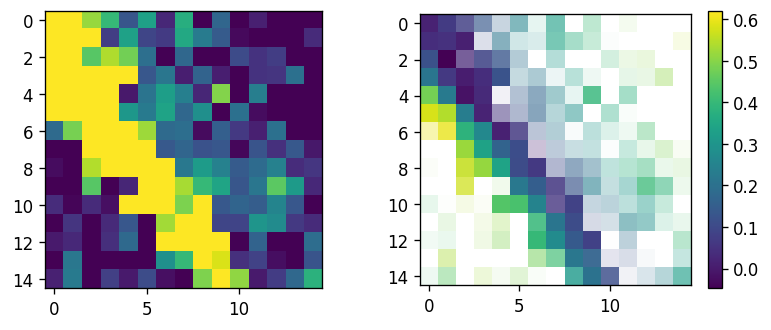

In [14]:
alpha_map = get_alpha_map(im_std[0], vmin_p=0.2, vmax_p=0.8)

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(alpha_map)

plt.subplot(122)
plt.imshow(im_avg[0], alpha=alpha_map)

plt.colorbar()

In [ ]:
alpha_maps = [get_alpha_map(im_std[n], vmin_p=0.2, vmax_p=0.9) for n in range(3)]

fig, axs = plt.subplots(2, 3, figsize=(14, 8))
draw_orders(im_avg, axs=axs[0], ftitle=lambda x: r"$E[AC^2_d(%s)]$"%(next(titles)), clim=[0, 0.7])
draw_orders(im_avg, axs=axs[1], alpha_map=alpha_maps, ftitle=lambda x: r"$E[AC^2_d(%s)]$"%(next(titles)), clim=[0, 0.7])

# plt.show()

# show full result - with alpha map

In [228]:
def gen_full_figure(obj, order_dyna, id_r, id_p, w=15, dpi=120, vmin_p=0.1, vmax_p=0.8, show_diff=False, show_only_std=False, apply_alpha=False, pts=None, save_dir=None):
    
    # need to check option
    
    x = obj.controls["beta_set"]
    y = obj.controls["alpha_set"]
    xt = [0, 0.5, 1]
    yt = [0.5*i for i in range(5)]
    title_fontsize = 15
    
    if show_only_std:
        prefix = "\sigma"
        inv_prefix = "\sigma"
    elif show_diff:
        prefix = "\Delta E"
        inv_prefix = "\Delta (1/E)"
    else:
        prefix = "E"
        inv_prefix = "1/E"
    
    def draw_sub(im_set, im_std, **opt):
        if np.shape(im_set)[2] == 3:
            im_set = [im_set[:,:,n] for n in range(3)]
            im_std = [im_std[:,:,n] for n in range(3)]
            
        alpha_maps = None
        if im_std is not None:
            if apply_alpha:
                alpha_maps = [get_alpha_map(im_std[n], vmin_p=vmin_p, vmax_p=vmax_p) for n in range(3)]
            elif show_only_std:
                im_set = im_std
                opt["clim"] = [None, None]
        
        if show_diff:
            im_set = [im - im[0, 0] for im in im_set]
            
        return draw_orders(im_set, alpha_map=alpha_maps, x=x, y=y, xt=xt, yt=yt, title_fontsize=title_fontsize, **opt) 
        
    def get_orders(key):
        data = obj.summary[key][:,:,id_r,id_p,:,:]
        data_avg = np.nanmean(data, axis=2)
        data_std = np.nanstd(data, axis=2)
        return data_avg, data_std
    
    def draw_single(im, ax0, im_std=None, clim=None, title=None, cmap="jet", show_diff=False):
        if clim is None:
            clim = [None, None]
        
        alpha_map = None
        if im_std is not None:
            if apply_alpha:
                alpha_map = get_alpha_map(im_std, vmin_p=vmin_p, vmax_p=vmax_p)
            elif show_only_std:
                im = im_std
                clim = [None, None]
        
        if show_diff:
            im = im - im[0, 0]
        
        plt.axes(ax0)
        im_ax = hhtools.imshow_xy(im, x=x, y=y, vmax=clim[1], vmin=clim[0], alpha=alpha_map, cmap=cmap)
        plt.title(title, fontsize=title_fontsize)
        plt.xticks(xt)
        plt.yticks(yt)
        cbar = plt.colorbar()
        
        return im_ax, cbar
    
    def get_cl(clim):
        clim = np.array(clim)
        if show_diff:
            clim = clim - np.average(clim)
        return clim
        
    import itertools
    titles = itertools.cycle(iter(["T", "F", "S"]))
    
    fig, axs = plt.subplots(7, 4, dpi=dpi, figsize=(w, w*np.sqrt(2)))
    
    # ---------------------  Firing rate ---------------------
    fr_avg, fr_std = get_orders("frs_m")
    cl = get_cl([0, 10])
    draw_sub(fr_avg, fr_std, axs=axs[0][:3], clim=cl, ftitle=lambda x: r"$%s[fr(%s)]$"%(prefix, next(titles)))
    
    # ---------------------  Chi ---------------------
    chi_avg, chi_std = get_orders("chi")
    cl = get_cl([0, 0.2+0.6*id_r]) 
    draw_sub(chi_avg, chi_std, axs=axs[1][:3], clim=cl, ftitle=lambda x: r"$%s[\chi(%s)]$"%(prefix, next(titles)))
    
    # --------------------- CV -----------------------
    cv_avg, _ = get_orders("cv")
    draw_single(cv_avg[:,:,1], axs[0][3], clim=(0, 1), title=r"$E[CV(F)]$", show_diff=False)
    draw_single(cv_avg[:,:,2], axs[1][3], clim=(0, 1), title=r"$E[CV(S)]$", show_diff=False)
    
    # ---------------------  AC2_D ---------------------
    ac2d_avg, ac2d_std = concat_image(order_dyna, "ac2p_1st", id_r, id_p)
    clim = get_cl([0, 0.5+0.3*id_r])
    draw_sub(ac2d_avg, ac2d_std, axs=axs[2][:3], clim=clim, ftitle=lambda x: r"$%s[AC_{2,D}(%s)]$"%(prefix, next(titles)))
    
    # ---------------------  AC2_P ---------------------
    ac2d_avg, ac2d_std = concat_image(order_dyna, "ac2p_large", id_r, id_p)
    draw_sub(ac2d_avg, ac2d_std, axs=axs[3][:3], clim=clim, ftitle=lambda x: r"$%s[AC_{2,P}(%s)]$"%(prefix, next(titles)))
    
    # ---------------------  tau_D ---------------------    
    tau_avg_1st, tau_std =concat_image(order_dyna, "ac2t_1st", id_r, id_p)
    clim = get_cl([20, 50+30*id_r])
    draw_sub(1/tau_avg_1st, tau_std, axs=axs[4][:3], clim=clim, ftitle=lambda x: r"$%s[\tau_{2,D}(%s)]$"%(inv_prefix, next(titles)))
    
    # ---------------------  tau_P ---------------------
    tau_avg_large, tau_std = concat_image(order_dyna, "ac2t_large", id_r, id_p)
    draw_sub(1/tau_avg_large, tau_std, axs=axs[5][:3], clim=clim, ftitle=lambda x: r"$%s[\tau_{2,P}(%s)]$"%(inv_prefix, next(titles)))
    
    # ---------------------  delta tau ---------------------
    del_t = 1/tau_avg_1st - 1/tau_avg_large
    clim = get_cl([0, 20*(id_r+1)])
    draw_sub(del_t, None, axs=axs[6][:3], clim=clim, ftitle=lambda x: r"$1/E[\tau_{2,D}]-1/E[\tau_{2,P}](%s)$"%(next(titles)))
    
    # ---------------------  CC ---------------------
    cc_avg = order_dyna["cc1p_large"]["mean"][:,:,id_r,id_p]
    cc_std = order_dyna["cc1p_large"]["std"][:,:,id_r,id_p]
    draw_single(cc_avg, axs[3][3], im_std=cc_std, clim=(0, 0.8+0.2*id_r), title=r"$%s[CC_1]$"%(prefix))
    
    # ---------------------  Ratio of Leading ---------------------
    tau_cc = order_dyna["cc1t_large"][:,:,id_r,id_p,:]
    # remove which have only 1 point differnce
    ind = np.abs(tau_cc * fs) < 2
    tau_cc[ind] = 0
    
    pos_ratio = np.sum(tau_cc > 0, axis=2) / tau_cc.shape[2]
    pos_ratio -= np.sum(tau_cc < 0, axis=2) / tau_cc.shape[2]
    pos_ratio[pos_ratio == 0] = np.nan
    _, cbar = draw_single(pos_ratio, axs[4][3], clim=(-1, 1), title="Ratio of leading", show_diff=False)
    cbar.ax.set_yticks([-1, 0, 1])
    cbar.ax.set_yticklabels(['1 (F>)', '0', '1 (S>)'])
    
    # ---------------------  Sum of leading case ---------------------
    sum_ratio = np.sum(tau_cc > 0, axis=2) / tau_cc.shape[2]
    sum_ratio += np.sum(tau_cc < 0, axis=2) / tau_cc.shape[2]
    sum_ratio[sum_ratio == 0] = np.nan
    _, cbar = draw_single(sum_ratio, axs[5][3], clim=(0, 1), title="Leading ratio (any pop)", show_diff=False)
    cbar.ax.set_yticks([0, 1])
    cbar.ax.set_yticklabels(['0', '1'])
    
    # ---------------------  Delta Phi ---------------------
    tau_cc_avg = np.average(tau_cc, axis=2)
    id_u = pos_ratio > 0.05
    id_d = pos_ratio < -0.05
    
    dphi = np.zeros(tau_cc.shape[:2])
    dphi[id_u] = tau_cc_avg[id_u] / tau_avg_large[1][id_u]
    dphi[id_d] = -tau_cc_avg[id_d] / tau_avg_large[2][id_d]
    dphi[np.isnan(pos_ratio)] = np.nan
    
    _, cbar = draw_single(dphi, axs[6][3], clim=(0, 0.1), title=r"$E[t_{lag,cc}]/E[T_{leader}]$", show_diff=False)
    cbar.ax.set_yticks([0, 0.1])
    
    # ---------------------  White board ---------------------
    im = np.zeros([len(y), len(x), 3])
    im[:,:,1:] = 0.5
    _, cbar = draw_single(im, axs[2][3], show_diff=False)
    cbar.ax.set_yticks([])
    plt.xlabel(r"$\beta$", fontsize=15)
    plt.ylabel(r"$\alpha$", fontsize=15)
    axs[2][3].xaxis.set_label_coords(.5, .15)
    axs[2][3].yaxis.set_label_coords(.15, .5)
    
    # ---------------------  pts ---------------------
    cmap = hhtools.get_palette("gray")
    if pts is not None:
        for i in range(len(axs)):
            for j in range(len(axs[0])):
                if i == 6 and j == 3:
                    continue
                for n, r in enumerate(pts):
                    nr, nc = r[0], r[1]
                    c = cmap((n+0.5)/len(pts))
                    axs[i][j].plot(x[nc], y[nr], "p", c=c, markersize=5)
    
        for n, r in enumerate(pts):
            nr, nc = r[0], r[1]
            c = cmap((n+0.5)/len(pts))
            axs[2][3].text(x[nc], y[nr]+0.05, "%d"%(n), c=c, fontsize=14, horizontalalignment="center")
    
    # ----------- super title and save
    pr = obj.controls["p_ratio_set"][id_p]
    plt.suptitle("rank=%d, pr=%.2f"%(id_r, pr), fontsize=title_fontsize+5)
    
    plt.tight_layout()
    
    if save_dir is not None:
        if show_only_std:
            tag = "std"
        elif apply_alpha:
            tag = "alpha"
        elif show_diff:
            tag = "davg"
        else:
            tag = "avg"
        
        
        fig_name = os.path.join(save_dir, "summary_r%d_pr%.2f(%d)_%s"%(id_r, pr, id_p, tag))
        
        if pts is not None:
            fig_name += "_pts"
        
        plt.savefig(fig_name+".pdf", format="pdf", dpi=150, backend="Cairo")
    

In [ ]:
# Test
gen_full_figure(obj, order_dyna, 1, 5, dpi=80, vmin_p=0.2, vmax_p=0.8, apply_alpha=False, show_only_std=False, save_dir=None, show_diff=False)

In [ ]:
from IPython.display import clear_output
for i in range(2):
    for j in range(7):
        for apply_alpha in [True, False]:
            gen_full_figure(obj, order_dyna, i, j, dpi=80, vmin_p=0.2, vmax_p=0.8, apply_alpha=apply_alpha, show_only_std=False, save_dir="figures_new")
        gen_full_figure(obj, order_dyna, i, j, dpi=80, vmin_p=0.2, vmax_p=0.8, apply_alpha=False, show_only_std=True, save_dir="figures_new")
        gen_full_figure(obj, order_dyna, i, j, dpi=80, vmin_p=0.2, vmax_p=0.8, apply_alpha=False, show_diff=True, show_only_std=False, save_dir="figures_new")
        
        clear_output(wait=False)
    clear_output(wait=False)

## Check detail 

In [ ]:
# Test
#
pts = [[14, 0], [14, 4], [9, 0], [7, 1], [10, 4], [7, 5], [5, 5], [5, 7], [5, 9], [5, 12]] # idr=1, idpr=5
# pts = [[14, 0], [14, 1], [14, 2], [14, 4], [14, 14], [9, 0], [8, 0], [1, 2]]
    
nid = 1
npr = 5

gen_full_figure(obj, order_dyna, nid, npr, dpi=80, vmin_p=0.2, vmax_p=0.8, apply_alpha=False, show_only_std=False, save_dir="./check_nid=%d_npr=%d"%(nid, npr), show_diff=False, pts=pts)
gen_full_figure(obj, order_dyna, nid, npr, dpi=80, vmin_p=0.2, vmax_p=0.8, apply_alpha=False, show_only_std=True, save_dir="./check_nid=%d_npr=%d"%(nid, npr), show_diff=False, pts=pts)

In [131]:
def draw_quadratic_summary(data, fname=None, xl_raster=(1500, 2500), nsamples=20, wbin_t=1, fs=2000):
    
    from tqdm.notebook import tqdm
    from scipy.ndimage import gaussian_filter1d
    
    teq = 0.5
    
    plt.figure(dpi=100, figsize=(9, 12))
    plt.axes([0.1, 0.8, 0.8, 0.15])
    hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=[1500, 2500])
    plt.ylabel("# neuron", fontsize=14)
    plt.xlabel("Time (ms)", fontsize=14)
    
    title = "nid: %d"%(data["nid"][0])
    for n in data["nid"][1:]:
        title += ",%d"%(n)
    plt.title(title, fontsize=14)

    plt.twinx()
    t = data["ts"] * 1e3
    plt.plot(t, data["vlfp"][0], c='k', zorder=10, label=r"$V_T$")
    plt.plot(t, data["vlfp"][1], c='b', lw=1, label=r"$V_F$")
    plt.plot(t, data["vlfp"][2], c='r', lw=1, label=r"$V_S$")
    plt.legend(fontsize=14, loc="upper left", ncol=3, edgecolor="none")
    plt.ylabel("V", fontsize=14)
    
    # ----------------- Generate AC for x -----------------#
    t0_set = np.random.uniform(low=teq, high=data["ts"][-1]-wbin_t, size=nsamples)
    cc_set = [[] for _ in range(4)]
    for t0 in tqdm(t0_set):
        n0 = int(t0 * fs)
        n1 = n0 + wbin_t * fs

        for i in range(4):
            if i < 3:
                x = data["vlfp"][i][n0:n1]
                y = x.copy()
            else:
                x = data["vlfp"][1][n0:n1]
                y = data["vlfp"][2][n0:n1]

            cc, tlag = hhsignal.get_correlation(x, y, fs, max_lag=0.1)
            cc_set[i].append(cc)

    cc_set_avg = np.average(cc_set, axis=1)
    cc_set_std = np.std(cc_set, axis=1)
    
    # ----------------- Draw AC for x -----------------#
    labels = ["AC(T)", "AC(F)", "AC(S)", "CC(F, S)"]
    yl = [-0.8, 1.1]

    for n in range(4):
        # plt.subplot(1, 4, n+1)
        plt.axes([0.1+0.22*n, 0.6, 0.15, 0.15])
        plt.plot([0, 0], yl, 'g--', lw=1)
        plt.plot([-0.1, 0.1], [0, 0], 'g--', lw=1)
        plt.plot(tlag, cc_set_avg[n], c='k')
        plt.fill_between(tlag, cc_set_avg[n]-cc_set_std[n]/2, cc_set_avg[n]+cc_set_std[n]/2, alpha=0.5, color='k', edgecolor="none")
        plt.xlim([-0.1, 0.1])
        plt.xlabel(r"$\Delta t$ (s)", fontsize=14)
        plt.title(labels[n], fontsize=14)
        plt.ylim(yl)
        if n == 3:
            plt.text(-0.06, -0.7, r"$V_F$ lead", horizontalalignment="center")
            plt.text(0.06, -0.7, r"$V_S$ lead", horizontalalignment="center")
        
    # ----------------- Draw figure -----------------#
    tags = ["T", "F", "S"]
    xt = np.arange(0.5, 4.1, 0.5)
    for nid in range(3):

        psd, ff, tf = hhsignal.get_stfft(data["vlfp"][nid], data["ts"], 2000, frange=[2, 100])
        yf, f = hhsignal.get_fft(data["vlfp"][nid], 2000, frange=[2, 100])

        plt.axes([0.1, 0.4-0.17*nid, 0.7, 0.15])
        hhtools.imshow_xy(psd, x=tf, y=ff, cmap="jet", interpolation="spline16")
        plt.ylabel("frequency (%s) (Hz)"%(tags[nid]), fontsize=14)
        plt.ylim([2, 95])
        plt.colorbar()

        if nid < 2:
            plt.xticks(xt, labels=["" for _ in xt])
        else:
            plt.xticks(xt)
            plt.xlabel("Time (s)", fontsize=14)

        plt.axes([0.8, 0.4-0.17*nid, 0.11, 0.15])
        yf_s = gaussian_filter1d(yf, 3)
        plt.plot(yf, f, c='k')
        plt.plot(yf_s, f, c='r', lw=1.5)
        plt.xlabel(r"FFT($V_{%s}$)"%(tags[nid]), fontsize=14)
        plt.ylim([2, 95])
        
    if fname is not None:
        plt.savefig(fname, dpi=150)
    
    plt.show()

In [ ]:
for n in range(len(pts)):
    data = obj.load_detail(pts[n][0], pts[n][1], nid, npr, 0)
    
    fname = "./check_nid=%d_npr=%d/sample_ptr%d.png"%(nid, npr, n)
    draw_quadratic_summary(data, fname=fname)

In [246]:
np.average(order_dyna["ac2p_1st"]["std"][pts[1][0], pts[1][1], nid, npr, 1])

0.15544941929305803

  0%|          | 0/20 [00:00<?, ?it/s]

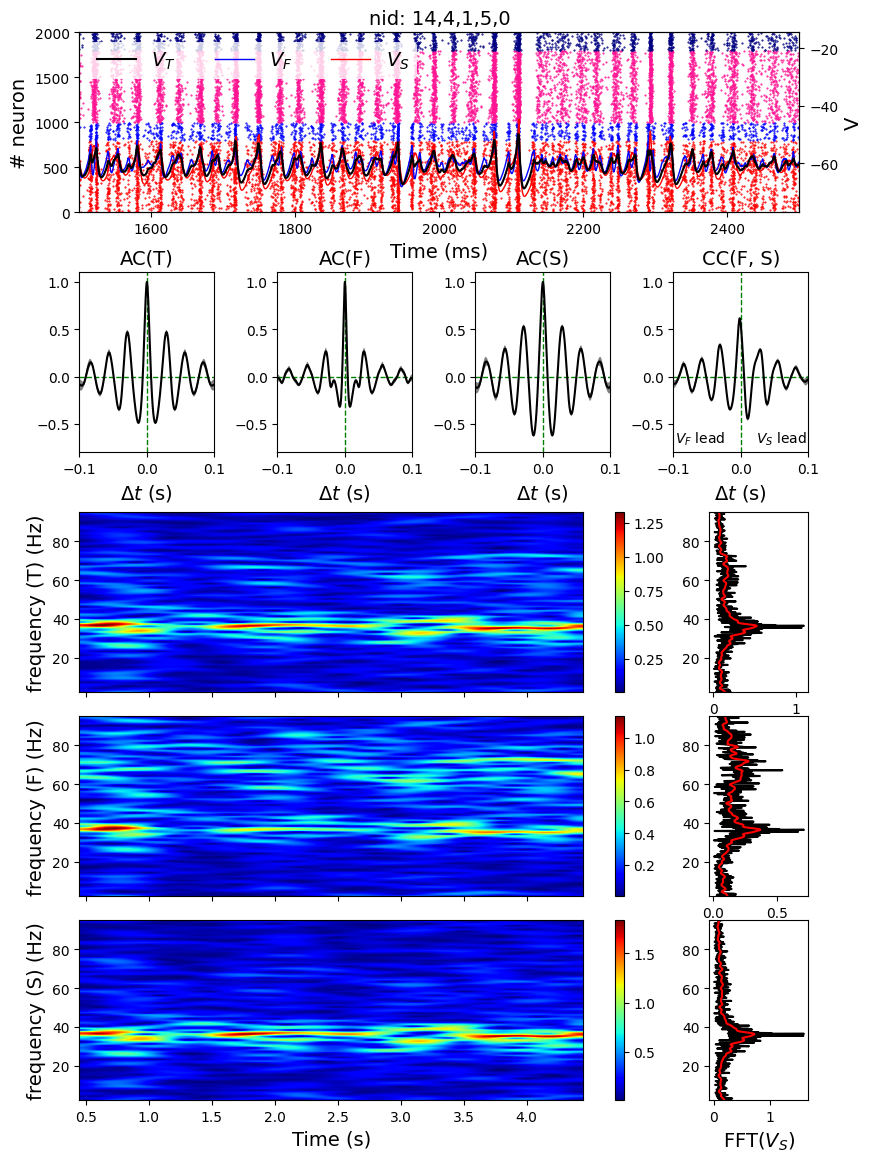

In [239]:
data = obj.load_detail(pts[1][0], pts[1][1], nid, npr, 0)
draw_quadratic_summary(data, fname=None)

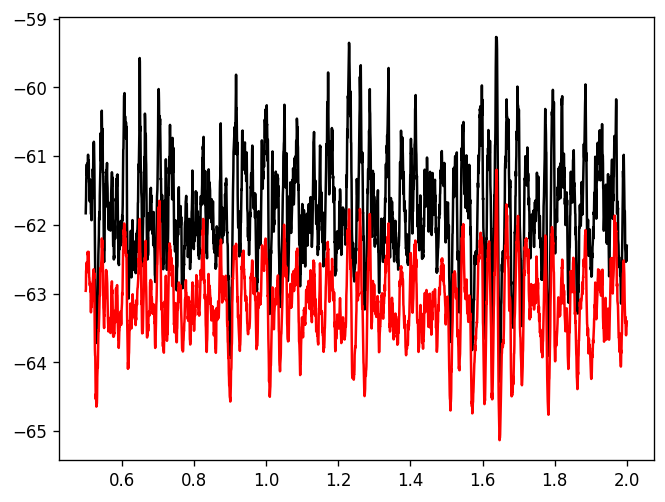

In [165]:
idt = (data["ts"] > 0.5) & (data["ts"] < 2)

plt.figure()
plt.plot(data["ts"][idt], data["vlfp"][1][idt], c='k')
plt.plot(data["ts"][idt], data["vlfp"][2][idt], c='r')
plt.show()

In [180]:
data = obj.load_detail(5, 12, nid, npr, 1)

In [181]:
idt = (data["ts"] > 1) & (data["ts"] < 2)
cc, tlag = hhsignal.get_correlation(data["vlfp"][1][idt], data["vlfp"][2][idt], 2000, max_lag=0.2)

p = hhsignal.detect_peak(cc, mode=0)
print(p)

[400 454 344 284 517 227 573 174 626 131 670 714  84 761  35]


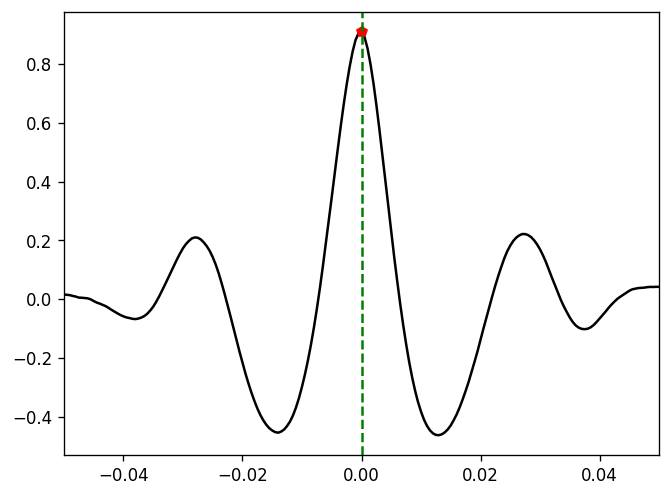

1.6653345369377348e-16


In [182]:
plt.figure()
plt.plot(tlag, cc, 'k')
plt.plot(tlag[p[0]], cc[p[0]], 'rp')
yl = plt.ylim()
plt.plot([0, 0], yl, 'g--')
plt.ylim(yl)
plt.xlim([-0.05, 0.05])
plt.show()

print(tlag[p[0]])

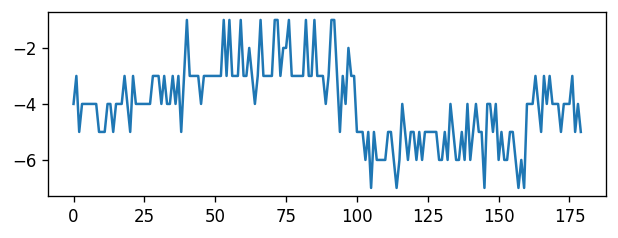

In [191]:
sub = order_dyna["cc1t_large"][14,0,nid,npr,:]

plt.figure(figsize=(6, 2))
plt.plot(sub * 2000)
plt.show()

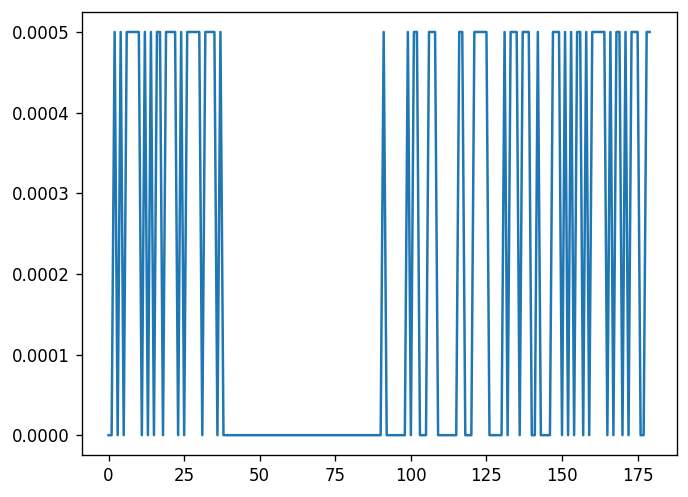

In [186]:
plt.plot(sub)

In [173]:
0.0005 * 2000

1.0

In [159]:
tlag[p[0]]

0.000500000000000167

In [156]:
p = hhsignal.detect_peak(cc, mode=0)
print(p)

[401 351 452 299 507 251 554 186 616 131 102 707  41 762]


In [154]:
p

array([401, 351, 452, 299, 507, 251, 554, 186, 616, 131, 102, 707,  41,
       762])

In [ ]:
np.concatenate(

In [100]:
order_dyna["ac2p_1st"].keys()

dict_keys(['mean', 'std'])

In [127]:
order_dyna["ac2p_1st"]["std"][1, 3, 0, 5, 2]

0.10191482421307306

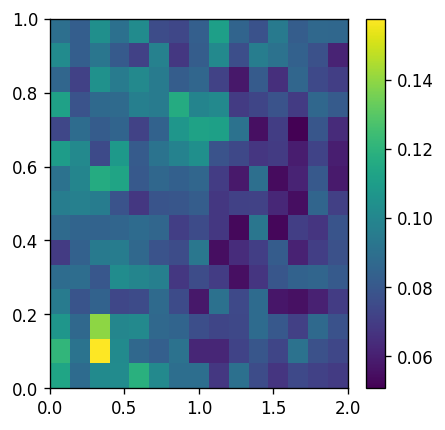

In [117]:
plt.figure(figsize=(4,4))
hhtools.imshow_xy(order_dyna["ac2p_1st"]["std"][:,:,0,5,2], x=obj.controls["alpha_set"], y=obj.controls["beta_set"])
plt.colorbar()
plt.show()

NameError: name 't' is not defined

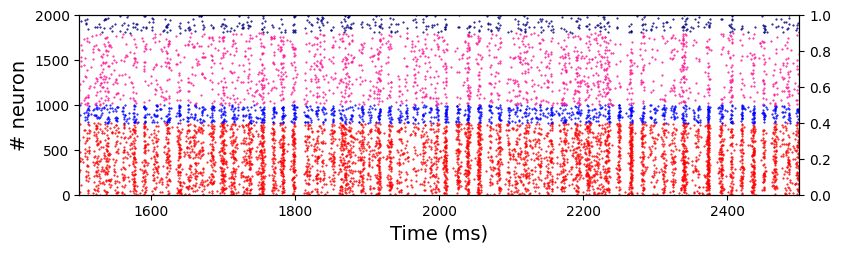

In [67]:
plt.figure(dpi=100, figsize=(9, 12))
# Raster plot
plt.axes([0.1, 0.8, 0.8, 0.15])
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=[1500, 2500])
plt.ylabel("# neuron", fontsize=14)
plt.xlabel("Time (ms)", fontsize=14)

plt.twinx()
plt.plot(t, data["vlfp"][0], c='k', zorder=10, label=r"$V_T$")
plt.plot(t, data["vlfp"][1], c='b', lw=1, label=r"$V_F$")
plt.plot(t, data["vlfp"][2], c='r', lw=1, label=r"$V_S$")
plt.legend(fontsize=14, loc="upper left", ncol=3, edgecolor="none")
plt.ylabel("V", fontsize=14)

# Auto-correlation

wbin_t = 1
nsamples = 20

fs = 2000
t0_set = np.random.uniform(low=teq, high=data["ts"][-1]-wbin_t, size=nsamples)
cc_set = [[] for _ in range(4)]

for t0 in tqdm(t0_set):
    n0 = int(t0 * fs)
    n1 = n0 + wbin_t * fs
    
    for i in range(4):
        if i < 3:
            x = data["vlfp"][i][n0:n1]
            y = x.copy()
        else:
            x = data["vlfp"][1][n0:n1]
            y = data["vlfp"][2][n0:n1]

        cc, tlag = hhsignal.get_correlation(x, y, fs, max_lag=0.1)
        cc_set[i].append(cc)
        
cc_set_avg = np.average(cc_set, axis=1)
cc_set_std = np.std(cc_set, axis=1)

# ----------------- Draw figure -----------------#
labels = ["AC(T)", "AC(F)", "AC(S)", "CC(F, S)"]
yl = [-0.8, 1.1]

for n in range(4):
    # plt.subplot(1, 4, n+1)
    plt.axes([0.1+0.22*n, 0.6, 0.15, 0.15])
    plt.plot([0, 0], yl, 'g--', lw=1)
    plt.plot([-0.1, 0.1], [0, 0], 'g--', lw=1)
    plt.plot(tlag, cc_set_avg[n], c='k')
    plt.fill_between(tlag, cc_set_avg[n]-cc_set_std[n]/2, cc_set_avg[n]+cc_set_std[n]/2, alpha=0.5, color='k', edgecolor="none")
    plt.xlim([-0.1, 0.1])
    plt.ylim([-0.8, 1.1])
    plt.xlabel(r"$\Delta t$ (s)", fontsize=14)
    plt.title(labels[n], fontsize=14)
    
    if n == 3:
        plt.text(-0.07, -0.7, r"$V_F$ lead", horizontalalignment="center")
        plt.text(0.07, -0.7, r"$V_S$ lead", horizontalalignment="center")
    
# ----------------- Draw figure -----------------#
tags = ["T", "F", "S"]
xt = np.arange(0.5, 4.1, 0.5)
for nid in range(3):
    
    psd, ff, tf = hhsignal.get_stfft(data["vlfp"][nid], data["ts"], 2000, frange=[2, 100])
    yf, f = hhsignal.get_fft(data["vlfp"][nid], 2000, frange=[2, 100])
    
    plt.axes([0.1, 0.4-0.17*nid, 0.7, 0.15])
    hhtools.imshow_xy(psd, x=tf, y=ff, cmap="jet", interpolation="spline16")
    plt.ylabel("frequency (%s) (Hz)"%(tags[nid]), fontsize=14)
    plt.ylim([2, 95])
    plt.colorbar()
    
    if nid < 2:
        plt.xticks(xt, labels=["" for _ in xt])
    else:
        plt.xticks(xt)
        plt.xlabel("Time (s)", fontsize=14)
    
    plt.axes([0.8, 0.4-0.17*nid, 0.11, 0.15])
    yf_s = gaussian_filter1d(yf, 3)
    plt.plot(yf, f, c='k')
    plt.plot(yf_s, f, c='r', lw=1.5)
    plt.xlabel(r"FFT($V_{%s}$)"%(tags[nid]), fontsize=14)
    plt.ylim([2, 95])
    
plt.show()

In [1133]:
nid = 3

# data = obj.load_detail(pts[nid][0], pts[nid][1], 1, 5, 0)
data = obj.load_detail(pts[nid][0], pts[nid][1], 0, 5, 0)
# data = obj.load_detail(14, 1, 0, 4, 0)

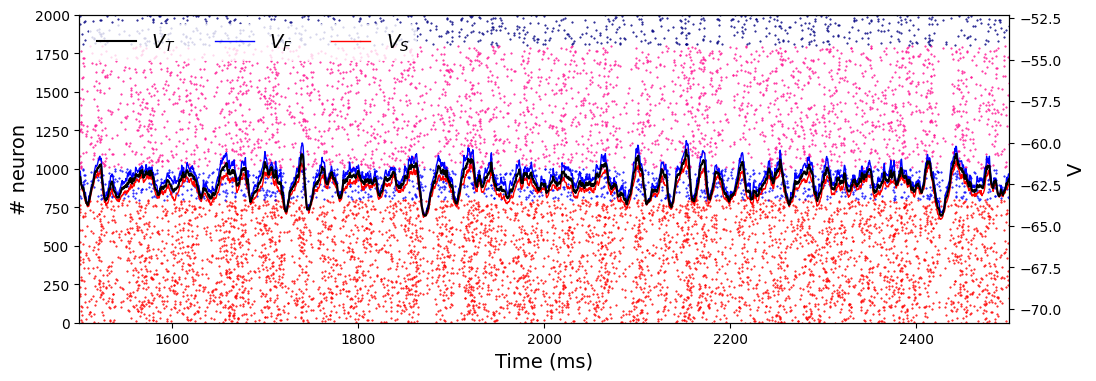

In [1134]:
plt.figure(dpi=100, figsize=(12, 4))
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=[1500, 2500])
plt.ylabel("# neuron", fontsize=14)
plt.xlabel("Time (ms)", fontsize=14)

plt.twinx()
plt.plot(t, data["vlfp"][0], c='k', zorder=10, label=r"$V_T$")
plt.plot(t, data["vlfp"][1], c='b', lw=1, label=r"$V_F$")
plt.plot(t, data["vlfp"][2], c='r', lw=1, label=r"$V_S$")
plt.legend(fontsize=14, loc="upper left", ncol=3, edgecolor="none")
plt.ylabel("V", fontsize=14)

plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

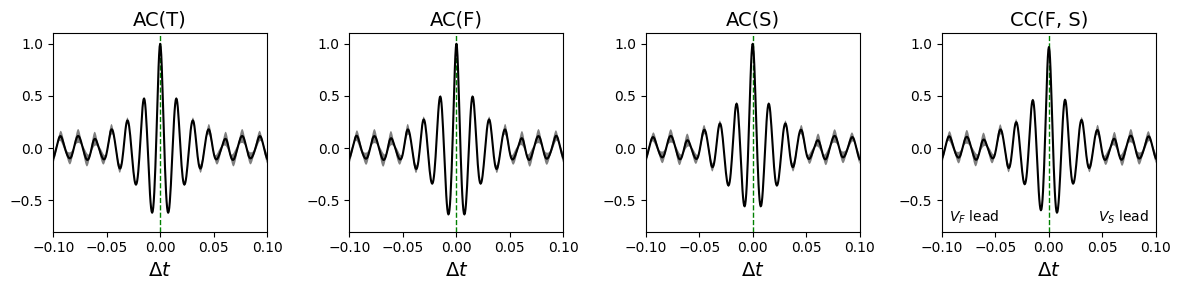

In [66]:
from tqdm.notebook import tqdm

teq = 0.5
wbin_t = 1
nsamples = 10

fs = 2000
t0_set = np.random.uniform(low=teq, high=data["ts"][-1]-wbin_t, size=nsamples)
cc_set = [[] for _ in range(4)]

for t0 in tqdm(t0_set):
    n0 = int(t0 * fs)
    n1 = n0 + wbin_t * fs
    
    for i in range(4):
        if i < 3:
            x = data["vlfp"][i][n0:n1]
            y = x.copy()
        else:
            x = data["vlfp"][1][n0:n1]
            y = data["vlfp"][2][n0:n1]

        cc, tlag = hhsignal.get_correlation(x, y, fs, max_lag=0.1)
        cc_set[i].append(cc)
        
cc_set_avg = np.average(cc_set, axis=1)
cc_set_std = np.std(cc_set, axis=1)

# ----------------- Draw figure -----------------#
labels = ["AC(T)", "AC(F)", "AC(S)", "CC(F, S)"]
yl = [-0.8, 1.1]

plt.figure(dpi=100, figsize=(12, 3))
for n in range(4):
    plt.subplot(1, 4, n+1)
    plt.plot([0, 0], yl, 'g--', lw=1)
    plt.plot(tlag, cc_set_avg[n], c='k')
    plt.fill_between(tlag, cc_set_avg[n]-cc_set_std[n]/2, cc_set_avg[n]+cc_set_std[n]/2, alpha=0.5, color='k', edgecolor="none")
    plt.xlim([-0.1, 0.1])
    plt.xlabel(r"$\Delta t$", fontsize=14)
    plt.title(labels[n], fontsize=14)
    plt.ylim([-0.8, 1.1])
    
    if n == 3:
        plt.text(-0.07, -0.7, r"$V_F$ lead", horizontalalignment="center")
        plt.text(0.07, -0.7, r"$V_S$ lead", horizontalalignment="center")
    
plt.tight_layout()
plt.show()    

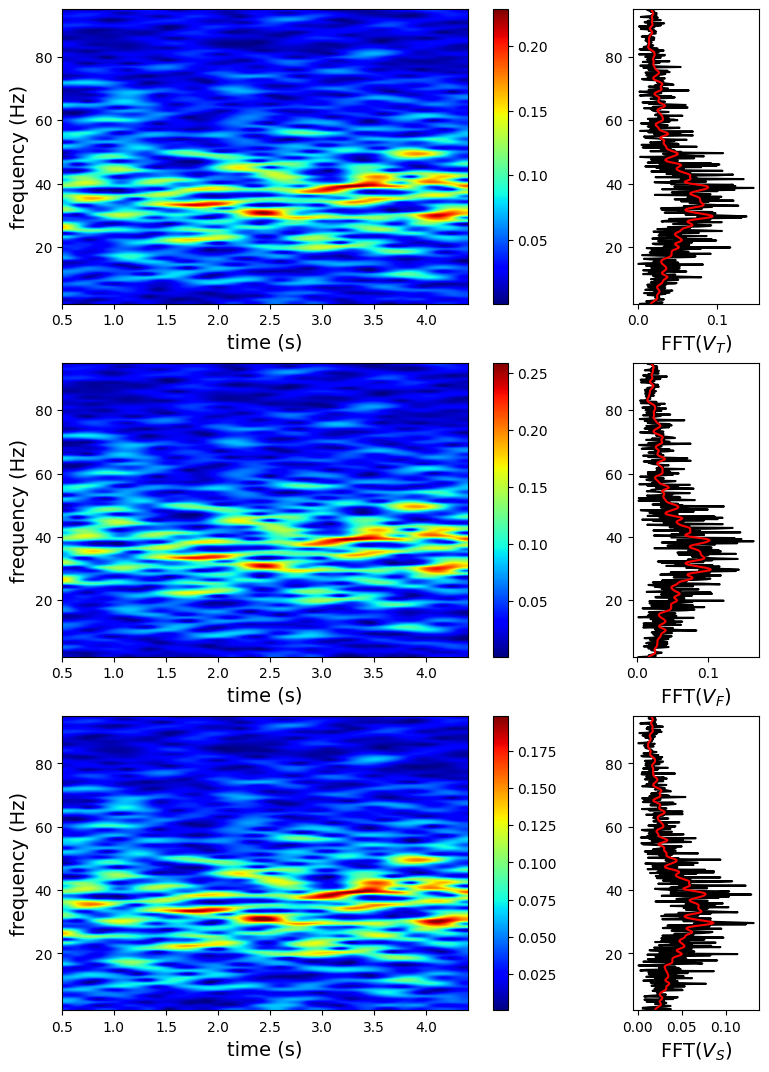

In [1136]:
from scipy.ndimage import gaussian_filter1d

tags = ["T", "F", "S"]

fig, axs = plt.subplots(3,2, dpi=100, figsize=(9, 13), gridspec_kw={"width_ratios": [0.8, 0.2]})

for nid in range(3):
    
    psd, ff, tf = hhsignal.get_stfft(data["vlfp"][nid], data["ts"], 2000, frange=[2, 100])
    yf, f = hhsignal.get_fft(data["vlfp"][nid], 2000, frange=[2, 100])
    
    plt.axes(axs[nid][0])
    hhtools.imshow_xy(psd, x=tf, y=ff, cmap="jet", interpolation="spline16")
    plt.xlabel("time (s)", fontsize=14)
    plt.ylabel("frequency (Hz)", fontsize=14)
    plt.ylim([2, 95])
    plt.colorbar()

    plt.axes(axs[nid][1])
    yf_s = gaussian_filter1d(yf, 3)
    plt.plot(yf, f, c='k')
    plt.plot(yf_s, f, c='r', lw=1.5)
    plt.xlabel(r"FFT($V_{%s}$)"%(tags[nid]), fontsize=14)
    plt.ylim([2, 95])

plt.show()

# Full 

In [ ]:
import pickle as pkl
# with open("./asym_link_full_out.pkl", "rb") as fp:
with open("./tmp_out.pkl", "rb") as fp:
    order_dyna = pkl.load(fp)

In [333]:
def draw_pts(rs, cs, npt):
    if npt is None:
        return
    
    cmap = hhtools.get_palette("gray")
    for i, nrc in enumerate(npt):
        nr, nc = nrc[0], nrc[1]
        c = cmap((i+0.5)/len(npt))
        plt.plot(cs[nc], rs[nr], "p", c=c, markersize=5)
        plt.text(cs[nc], rs[nr], "%d"%(i), c=c, fontsize=10)
                 

def generate_full_summary(id_rank, id_p, save=False, pts=None, fdir=None):
    x = obj.controls["beta_set"]
    y = obj.controls["alpha_set"]
    title_fontsize = 15

    def set_axis():
        plt.xticks([0, 0.5, 1])
        plt.yticks(np.arange(0, 2.1, 0.5))
        return plt.colorbar()

    w = 15
    tags = ["T", "F", "S"]
    fig = plt.figure(dpi=200, figsize=(w, w*np.sqrt(2)))

    # Firing rate
    for n in range(3):
        im = obj.summary["frs_m"][:,:,id_rank,id_p,:,n]

        plt.subplot(8,4,n+1)
        hhtools.imshow_xy(np.average(im, 2), x=x, y=y, cmap="jet", vmin=0, vmax=10)
        plt.title("E(fr(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)

        plt.subplot(8,4,n+5)
        # hhtools.imshow_xy(np.average(obj.summary["frs_s"][:,:,id_rank,id_p,:,n], 2), x=x, y=y, cmap="jet", vmin=0)
        hhtools.imshow_xy(np.std(im, 2), x=x, y=y, cmap="jet", vmin=0)
        plt.title(r"$\sigma$(fr(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)
                 
    # CV
    labels = ["CV(F)", "CV(S)"]
    for n in range(2):
        cv = obj.summary["cv"][:,:,id_rank,id_p,:,:]
        plt.subplot(8,4,(n+1)*4)
        hhtools.imshow_xy(np.average(cv[:,:,:,n+1], 2), x=x, y=y, cmap="jet", vmin=0, vmax=1)
        plt.title(labels[n], fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)

    # chi
    for n in range(3):
        # -----------------------------------------------
        im = obj.summary["chi"][:,:,id_rank,id_p,:,n]
        
        # -----------------------------------------------

        plt.subplot(8,4,n+9)
        hhtools.imshow_xy(np.nanmean(im, 2), x=x, y=y, cmap="jet", vmin=0, vmax=0.8)
        plt.title(r"E($\chi$(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)

        plt.subplot(8,4,n+13)
        hhtools.imshow_xy(np.nanstd(im, 2), x=x, y=y, cmap="jet", vmin=0)
        plt.title(r"$\sigma$($\chi$(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)

    # AC2
    for n in range(3):
        im = order_dyna["ac2_p"][:,:,id_rank,id_p,:,n]
        # show AC2 average
        plt.subplot(8,4,n+17)
        hhtools.imshow_xy(np.average(im, axis=2), cmap="jet", x=x, y=y, vmin=0, vmax=0.8)
        plt.title(r"E(AC2(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)
        # show AC2 std
        plt.subplot(8,4,n+21)
        hhtools.imshow_xy(np.std(im, axis=2), cmap="jet", x=x, y=y)
        plt.title(r"$\sigma$(AC2(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)

    # frequency
    for n in range(3):
        im = 1/order_dyna["ac2_lag"][:,:,id_rank,id_p,:,n]

        plt.subplot(8,4,n+25)
        hhtools.imshow_xy(np.average(im, axis=2), cmap="jet", x=x, y=y, vmin=20, vmax=80)
        plt.title(r"E(f(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)

        plt.subplot(8,4,n+29)
        hhtools.imshow_xy(np.std(im, axis=2), cmap="jet", x=x, y=y)
        plt.title(r"$\sigma$(f(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        draw_pts(y, x, pts)

    # CC
    im = order_dyna["cc_p"][:,:,id_rank,id_p,:]
    plt.subplot(8,4,20)
    hhtools.imshow_xy(np.average(im, axis=2), cmap="jet", x=x, y=y, vmin=0, vmax=0.8)
    plt.title(r"E(CC(F-S))", fontsize=title_fontsize)
    set_axis()
    draw_pts(y, x, pts)
    
    # show CC - std
    plt.subplot(8,4,24)
    hhtools.imshow_xy(np.std(im, axis=2), cmap="jet", x=x, y=y, vmin=0)
    plt.title(r"$\sigma$(CC(F-S))", fontsize=title_fontsize)
    set_axis()
    draw_pts(y, x, pts)
    
    # show lead/lag ratio
    plt.subplot(8,4,28)
    t_cc = order_dyna["cc_lag"][:,:,id_rank,id_p,:]
    pos_ratio = np.sum(t_cc > 0, axis=2) / t_cc.shape[2]*2-1
    hhtools.imshow_xy(pos_ratio, cmap="RdBu", x=x, y=y, vmin=-1, vmax=1)
    plt.title("Ratio of leading", fontsize=title_fontsize)
    cbar = set_axis()
    cbar.ax.set_yticks([-1, 0, 1])
    cbar.ax.set_yticklabels(['F>', '0', 'S>'])

    # dphs
    tol = 0.1
    plt.subplot(8,4,32)
    dphs = np.zeros_like(pos_ratio)
    # fast lead
    ind_f = pos_ratio < -tol
    T_f = order_dyna["ac2_lag"][:,:,id_rank,id_p,:,1]
    dphs[ind_f] = np.average(t_cc[ind_f,:] / T_f[ind_f,:], axis=1)

    # lead/lag relation 
    ind_s = pos_ratio > tol
    T_s = order_dyna["ac2_lag"][:,:,id_rank,id_p,:,2]
    dphs[ind_s] = np.average(t_cc[ind_s,:] / T_s[ind_s,:], axis=1)

    hhtools.imshow_xy(dphs, cmap="jet", vmin=-0.1, vmax=0.05, x=x, y=y)
    plt.title(r"$t_{lag,cc}/T_{leader}$", fontsize=title_fontsize)
    set_axis()
    draw_pts(y, x, pts)
    
    # show amount of leading
    plt.subplot(8,4,12)
    plt.ylabel(r"$\alpha$ (ratio of E proj)", fontsize=14)
    plt.xlabel(r"$\beta$ (ratio of I proj)", fontsize=14)
    plt.xlim([0, 1])
    plt.ylim([0, 2])
    plt.xticks([0, 0.5, 1])
    plt.yticks(np.arange(0, 2.1, 0.5))
    plt.title("id_rank=%d, p_ratio=%.2f"%(id_rank, obj.controls["p_ratio_set"][id_p]), fontsize=title_fontsize)
    draw_pts(y, x, pts)
    # plt.axis("off")

    plt.tight_layout()
    if save:
        if fdir is None:
            fdir = "./"
        if pts is None:
            plt.savefig(os.path.join(fdir, "asym_summary_r%d_pr%.2f.pdf"%(id_rank, obj.controls["p_ratio_set"][id_p])))
        else:
            plt.savefig(os.path.join(fdir, "asym_summary_r%d_pr%.2f_samples.pdf"%(id_rank, obj.controls["p_ratio_set"][id_p])))

    # plt.show()
    return fig

In [ ]:
# for idr in range(2):
#     for idp in range(7):
#         fig = generate_full_summary(idr, idp, save=True, pts=None, fdir="figures_new")

idr = 1
idp = 5

fig = generate_full_summary(idr, idp, save=False, pts=None, fdir="figures_new")

In [ ]:
plt.figure(figsize=(4,4))
hhtools.imshow_xy(np.std(order_dyna["ac2_p"][:, :, idr, idp, :, 0], axis=2), vmin=0.05, vmax=0.1, cmap="jet")
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(order_dyna["ac2_p"][13, 10, idr, idp, :, 0], edgecolor='k')
plt.show()

In [ ]:
order_dyna["fpeak"]["mean"].shape

In [ ]:
def draw_orders(im_set, axs=None, clim=None):
    for n in range(3):
        if axs is None:
            plt.subplot(1,3,n+1)
        else:
            plt.axes(axs[n])
        hhtools.imshow_xy(im_set[n], x=x, y=y, interpolation="none", clim=clim, cmap="jet")
        plt.colorbar()


def concat_image(key):
    im_avg_set = [order_dyna[key]["mean"][:,:,idr,idp,n] for n in range(3)]
    im_std_set = [order_dyna[key]["std"][:,:,idr,idp,n] for n in range(3)]
    return im_avg_set, im_std_set

In [ ]:
idr = 1
idp = 5

im_avg, im_std = concat_image("ac2p_1st")

plt.figure(dpi=120, figsize=(14, 4))
draw_orders(im_avg, clim=[0, 1])
plt.show()

plt.figure(dpi=120, figsize=(14, 4))
draw_orders(im_std, clim=[0, 0.3])
plt.show()

In [ ]:
idr = 1
idp = 5

im_avg, im_std = concat_image("ac2p_large")

plt.figure(dpi=120, figsize=(14, 4))
draw_orders(im_avg, clim=[0, 1])
plt.show()

plt.figure(dpi=120, figsize=(14, 4))
draw_orders(im_std, clim=[0, 0.1])
plt.show()

In [ ]:
idr = 1
idp = 5

# im_set = np.average(order_dyna["fpeak"]["mean"][:,:,idr,idp,:,], axis=2)
im_set = [order_dyna["ac2p_large"]["mean"][:,:,idr,idp,n]-order_dyna["ac2p_1st"]["mean"][:,:,idr,idp,n] for n in range(3)]

plt.figure(dpi=120, figsize=(14, 4))
draw_orders(im_set, clim=[-0.4, 0.4])
plt.show()

In [ ]:
idr = 1
idp = 5

# im_set = np.average(order_dyna["fpeak"]["mean"][:,:,idr,idp,:,], axis=2)
im_set = [order_dyna["ac2p_large"]["std"][:,:,idr,idp,n]-order_dyna["ac2p_1st"]["std"][:,:,idr,idp,n] for n in range(3)]

plt.figure(dpi=120, figsize=(14, 4))
draw_orders(im_set, clim=[-0.4, 0.4])
plt.show()

In [ ]:
1/0.035

In [ ]:
idr = 1
idp = 5

im_avg, im_std = concat_image("ac2t_1st")

plt.figure(dpi=120, figsize=(14, 4))
draw_orders(1/np.array(im_avg), clim=[20, 80])
plt.show()

plt.figure(dpi=120, figsize=(14, 4))
draw_orders(im_std, clim=[0, 0.01])
plt.show()

In [ ]:
idr = 1
idp = 5

im_avg, im_std = concat_image("ac2t_large")

plt.figure(dpi=120, figsize=(14, 4))
draw_orders(1/np.array(im_avg), clim=[20, 80])
plt.show()

plt.figure(dpi=120, figsize=(14, 4))
draw_orders(im_std, clim=[0, 0.01])
plt.show()

In [ ]:
idr = 1
idp = 2

# im_set = np.average(order_dyna["fpeak"]["mean"][:,:,idr,idp,:,], axis=2)
im_set = [1/order_dyna["ac2t_1st"]["mean"][:,:,idr,idp,n]-1/order_dyna["ac2t_large"]["mean"][:,:,idr,idp,n] for n in range(3)]

plt.figure(dpi=120, figsize=(14, 4))
draw_orders(im_set, clim=[0, 30])
plt.show()

In [ ]:
idr = 1
idp = 5

# im_set = np.average(order_dyna["fpeak"]["mean"][:,:,idr,idp,:,], axis=2)
im_set = [order_dyna["fpeak"]["std"][:,:,idr,idp,n] for n in range(3)]

plt.figure(dpi=120, figsize=(14, 4))
draw_orders(im_set)
plt.show()

In [ ]:
im_set = np.average(order_dyna["fpeak"][:,:,idr,idp,:,:], axis=2)
im_set = [im_set[:,:,n] for n in range(3)]

plt.figure(dpi=120, figsize=(14, 4))
draw_orders(np.log(im_set), clim=np.log([30, 50]))
plt.show()

In [ ]:
idr = 1
idp = 1
x = obj.controls["beta_set"]
y = obj.controls["alpha_set"]

im_set = np.std(order_dyna["fpeak"][:,:,idr,idp,:,:], axis=2)
im_set = [im_set[:,:,n] for n in range(3)]

plt.figure(dpi=120, figsize=(14, 4))
draw_orders(im_set, clim=None)
plt.show()

In [ ]:
im_set = np.average(order_dyna["ac2_p"][:,:,idr,idp,:,:], axis=2)
im_set = [im_set[:,:,n] for n in range(3)]

plt.figure(dpi=120, figsize=(14, 4))
draw_orders(im_set, clim=None)
plt.show()

In [ ]:
im_set.shape

In [ ]:
yf1, f1 = hhsignal.get_fft(data["vlfp"][1][idt], 2000, frange=[1, 100])

cc, tlag = hhsignal.get_correlation(data["vlfp"][1][idt], data["vlfp"][1][idt], 2000, max_lag=None)
yf2, f2 = hhsignal.get_fft(cc, 2000, frange=[1, 100])

plt.figure(dpi=120, figsize=(6,6))

plt.plot(f1, yf1, 'k')
plt.xticks(np.arange(0, 101, 5))
plt.xlim([20, 60])

plt.twinx()
plt.plot(f2, yf2, 'r')

plt.show()

In [ ]:
idp_tmp, _ = find_peaks(cc, prominence=0.02)

plt.figure(figsize=(4,4))
plt.plot(tlag, cc, 'k')
plt.plot(tlag[idp_tmp], cc[idp_tmp], "rp")
plt.show()

print(idp_tmp - len(cc)//2)
print(2e3/(idp_tmp - len(cc)//2))

In [ ]:
65*4 - 96

In [ ]:
plt.figure()
plt.plot(f, cc_fft, 'k.-')
plt.xlim([20, 60])
plt.xticks(np.arange(20, 70, 5))
plt.grid(True)
plt.show()

In [ ]:
psd, ff, tf = hhsignal.get_stfft(data["vlfp"][1], data["ts"], 2000, f_range=[3, 100])

plt.figure()
hhtools.imshow_xy(psd, x=tf, y=ff, cmap="jet", vmax=0.3, interpolation="spline16")
# plt.xlim([2, 4])
plt.show()

In [ ]:
plt.figure(dpi=120, figsize=(12, 3))
plt.plot(t, x, c='k')
plt.show()

In [ ]:
# hhsignal.get_correlation(data["vlfp"][1][idt], data["vlfp"][1][idt], 2000, max_lag=0.1)
x = data["vlfp"][1][idt]
x = x - np.average(x)

cc = np.correlate(x, x, mode="full")
cc = cc / len(x)

cc_fft, f = hhsignal.get_fft(cc, 2000, frange=[1, 100])
xf, f2 = hhsignal.get_fft(x, 2000, frange=[1, 100])

plt.figure()
plt.plot(f, cc_fft, c='k')
plt.xticks(np.arange(20, 60, 5))
plt.xlim([20, 50])

plt.twinx()
plt.plot(f2, xf, c='r')
plt.show()


In [ ]:
plt.figure(dpi=120, figsize=(12, 3))
t = np.arange(0, np.sum(idt))/2000
plt.plot(t, data["vlfp"][1][idt], 'k')
plt.xlim([0.6, 0.8])
plt.show()

In [ ]:
from scipy.signal import find_peaks
from scipy.signal import correlate

ind_peaks, _ = find_peaks(cc)

In [ ]:
from pprint import pprint

plt.figure()
plt.plot(tlag, cc)
plt.plot(tlag[ind_peaks], cc[ind_peaks], '.')
pprint(np.round(tlag[ind_peaks]*1e3, 1))
pprint(np.round(cc[ind_peaks], 3))

In [ ]:
data = obj.load_detail(0, 0, 0, 3, 3)
# data = obj.load_detail(2, 6, 1, 5, 0)

t0 = 2
wbin_t = 1
idt = (data["ts"] >= t0) & (data["ts"] < t0+wbin_t)
x = data["vlfp"][1][idt]

cc_tmp = correlate(x-np.average(x), x-np.average(x), mode="full", method="fft")
cc_tmp = cc_tmp / np.var(x) / len(x)
ind_peaks, _ = find_peaks(cc_tmp)
nid = np.argsort(cc_tmp[ind_peaks])[::-1]
ind_peaks = ind_peaks[nid[:5]]

plt.figure(dpi=120, figsize=(8, 3))

plt.subplot(121)
t = np.arange(-len(cc_tmp)//2, len(cc_tmp)//2)/2000
plt.plot(t, cc_tmp, 'k')
plt.plot(t[ind_peaks], cc_tmp[ind_peaks], 'r*', ms=6)
plt.plot(t[ind_peaks[:3]], cc_tmp[ind_peaks[:3]], 'b*', ms=4)

for n in ind_peaks:
    plt.text(t[n], cc_tmp[n]+0.1, "%.2f"%(cc_tmp[n]))
plt.xlim([-0.1, 0.1])
plt.xlabel(r"$\Delta t$", fontsize=14)
plt.ylabel("AC(F)", fontsize=14)

plt.subplot(122)
yf, f = hhsignal.get_fft(x, 2000, frange=[3, 100], nbin=100)
plt.plot(f, yf, 'k')
plt.xlabel("frequency (Hz)", fontsize=14)
plt.ylabel("Amplitude", fontsize=14)

print(f[np.argmax(yf)])

plt.tight_layout()
plt.show()

In [ ]:
cc_tmp = correlate(x-np.average(x), x-np.average(x), mode="full", method="fft")

In [ ]:
t = np.arange(-len(cc_tmp)//2, len(cc_tmp)//2)/2000

plt.figure()
plt.plot(t, cc_tmp)
plt.xlim([-0.1, 0.1])cc_tmp = correlate(x-np.average(x), x-np.average(x), mode="full", method="fft")
plt.show()

In [ ]:
x = data["vlfp"][1][idt]

In [ ]:
yf, f = hhsignal.get_fft(data["vlfp"][1][idt], 2000, frange=[3, 100])

plt.figure()
plt.plot(f, yf)
plt.show()

In [ ]:
plt.figure(dpi=120, figsize=(6, 3))
plt.plot(data["ts"][idt], data["vlfp"][1][idt])
plt.show()

In [ ]:
importlib.reload(hhsignal)

data = obj.load_detail(2, 8, 1, 5, 3)
# data = obj.load_detail(2, 6, 1, 5, 0)

t0 = 2
wbin_t = 1
idt = (data["ts"] >= t0) & (data["ts"] < t0+wbin_t)

cc, tlag = hhsignal.get_correlation(data["vlfp"][2][idt], data["vlfp"][2][idt], 2000, max_lag=0.1)
idp = hhsignal.find_corr_peaks(cc)
idp_old = hhsignal.find_corr_peaks_old(cc)

plt.figure(figsize=(3, 3))
plt.plot(tlag, cc, 'k', label="AC(S)")
plt.plot(tlag[idp], cc[idp], 'rp', label="modified")
plt.plot(tlag[idp_old], cc[idp_old], 'bp', label="old ver")
plt.legend(fontsize=10, loc="upper left")
print(tlag[idp][1:] * 1e3, cc[idp])
plt.xlabel(r"$\Delta t$", fontsize=14)
plt.ylabel("AC(S)")

plt.savefig("./figures/AC_change.png")
plt.show()

# Probe Single samples 

In [ ]:
for nn, pts in enumerate(pts_check):
    nr, nc = pts
    
    data = obj.load_detail(nr, nc, idr, idp, 0)

    xl = [2000, 3000]
    c_set = ["k", "r", "g"]
    lbs = ["T", "F", "S"]

    plt.figure(figsize=(9, 5.5))
    ax1 = plt.axes([0.1, 0.65, 0.55, 0.3])
    hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=xl)

    ax2 = plt.axes([0.1, 0.48, 0.55, 0.152])
    t = data["ts"] * 1e3
    for i in range(3):
        plt.plot(t[500:], data["vlfp"][i][500:], c_set[i])
    plt.xlim(xl)

    ax3 = plt.axes([0.1, 0.1, 0.55, 0.3])
    yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)
    hhtools.imshow_xy(yfft, x=t*1e3, y=f, cmap="jet", interpolation="spline16", vmax=1, vmin=0)
    plt.xlabel("time (ms)", fontsize=15)
    plt.colorbar()

    ax4 = plt.axes([0.75, 0.6, 0.2, 0.35])
    t = data["ts"] * 1e3
    idt = (t >= xl[0]) & (t <= xl[1])

    for i in range(3):
        v = data["vlfp"][i][idt]
        cc, tlag = hhsignal.get_correlation(v, v, 2000, max_lag=0.1)
        plt.plot(tlag, cc, c=c_set[i], label=lbs[i])
    plt.xlim([-0.1, 0.1])
    plt.ylabel("AC2")
    plt.legend(fontsize=8, ncol=3)

    ax5 = plt.axes([0.75, 0.1, 0.2, 0.35])

    cc, tlag = hhsignal.get_correlation(data["vlfp"][1][idt], data["vlfp"][2][idt], 2000, max_lag=0.1)

    plt.plot(tlag, cc, 'k')
    plt.xlim([-0.1, 0.1])
    plt.ylim([-1, 1])
    plt.ylabel("CC1(F, S)")
    
    pr = obj.controls["p_ratio_set"]
    plt.suptitle("id_r=%d, pr=%.2f, pts=%d"%(idr, pr[idp], nn))
    
    
    # plt.savefig(os.path.join(fdir, "sample_%d.png"%(nn)))
    plt.show()
    

In [ ]:
data = obj.load_detail(5, 10, 1, 0, 0)

xl = [2000, 3000]
c_set = ["k", "r", "g"]
lbs = ["T", "F", "S"]

plt.figure(figsize=(9, 4))
ax1 = plt.axes([0.1, 0.65, 0.55, 0.3])
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=xl)

ax2 = plt.axes([0.1, 0.48, 0.55, 0.152])
t = data["ts"] * 1e3
for i in range(3):
    plt.plot(t[500:], data["vlfp"][i][500:], c_set[i])
plt.xlim(xl)

ax3 = plt.axes([0.1, 0.1, 0.55, 0.3])
yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)
hhtools.imshow_xy(yfft, x=t*1e3, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (ms)", fontsize=15)

ax4 = plt.axes([0.75, 0.6, 0.2, 0.35])
t = data["ts"] * 1e3
idt = (t >= xl[0]) & (t <= xl[1])

for i in range(3):
    v = data["vlfp"][i][idt]
    cc, tlag = hhsignal.get_correlation(v, v, 2000, max_lag=0.1)
    plt.plot(tlag, cc, c=c_set[i], label=lbs[i])
plt.xlim([-0.1, 0.1])
plt.ylabel("AC2")
plt.legend(fontsize=8, ncol=3)

ax5 = plt.axes([0.75, 0.1, 0.2, 0.35])

cc, tlag = hhsignal.get_correlation(data["vlfp"][1][idt], data["vlfp"][2][idt], 2000, max_lag=0.1)

plt.plot(tlag, cc, 'k')
plt.xlim([-0.1, 0.1])
plt.ylabel("CC1(F, S)")

plt.show()

# Generate Single figure 

In [ ]:
data = obj.load_detail(0, 0, 0, 0, 0)

In [ ]:
# seq = np.random.randint(low=0, high=2000, size=100)
seq = np.random.choice(np.arange(2000), size=100, replace=False)

In [ ]:
hhtools.draw_spk(data["step_spk"], dt=0.01, colors='k', sequence=seq)

In [ ]:
data.keys()

In [ ]:
plt.figure()
for t in obj.t_s

In [ ]:
np.random.seed(100)

plt.figure(dpi=120, figsize=(8, 4sequence=




In [ ]:
id_r = 1
id_p = 3


xp = [x[nc] for nc in [3, 10]]
yp = [y[nr] for nr in [7, 4]]


plt.figure(figsize=(15, 20))
for n in range(3):
        im = 1/order_dyna["ac2_lag"][:,:,id_r,id_p,:,n]

        plt.subplot(8,4,n+25)
        hhtools.imshow_xy(np.average(im, axis=2), cmap="jet", x=x, y=y)
        plt.title(r"E(f(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        plt.plot(xp, yp, "wp", ms=10)

        plt.subplot(8,4,n+29)
        hhtools.imshow_xy(np.std(im, axis=2), cmap="jet", x=x, y=y)
        plt.title(r"$\sigma$(f(%s))"%(tags[n]), fontsize=title_fontsize)
        set_axis()
        plt.plot(xp, yp, "wp", ms=10)

In [ ]:
obj.control_names

In [ ]:
data = obj.load_detail(4,10,id_r,id_p,0)

In [ ]:
# data = obj.load_detail(12, 2, 2, 0)

plt.figure(dpi=120, figsize=(8, 3))
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(2500, 3000))

yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 100), wbin_t=0.5, mbin_t=0.01)
plt.figure(dpi=120, figsize=(6, 3))
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

In [ ]:
plt.figure(dpi=120, figsize=(6, 4))


# plt.plot(data["vlfp"][0])
# plt.plot(data["vlfp"][0])
# plt.plot(data["vlfp"][0])

In [ ]:
title_fontsize

In [ ]:
id_rank = 1
id_w = 1
n = 0

def logistic(x):
    return np.exp((x-1/2)*10)/(1+np.exp((x-1/2)*10))

im = np.average(1/order_dyna["ac2_lag"][:,:,id_rank,id_w,:,n], axis=2)

alpha = np.std(1/order_dyna["ac2_lag"][:,:,id_rank,id_w,:,n], axis=2)
alpha = (alpha - np.min(alpha)) / (np.max(alpha) - np.min(alpha))
alpha = logistic(alpha)


# hhtools.imshow_xy(, cmap="jet", x=x, y=y)

plt.figure(figsize=(9, 3))
plt.subplot(131)
hhtools.imshow_xy(im, x=x, y=y, alpha=alpha, cmap="jet")
plt.subplot(132)
hhtools.imshow_xy(im, x=x, y=y, cmap="jet")
plt.subplot(133)
hhtools.imshow_xy(alpha, x=x, y=y, cmap="jet")

In [ ]:
np.std(alpha)

In [ ]:
np.mean(alpha)

In [ ]:
np.max(alpha)

In [ ]:
np.min(alpha)

In [ ]:
id_w = 0
id_rank = 0

x = obj.controls["beta_set"]
y = obj.controls["alpha_set"]

def set_label():
    plt.xlabel(r"$\beta$", fontsize=15)
    plt.ylabel(r"$\alpha$", fontsize=15)
    plt.xticks([0, 0.5, 1])
    plt.yticks(np.arange(0, 2.1, 0.5))
    
plt.figure(
    

plt.figure(dpi=120, figsize=(12.5, 7))


for n in range(3):
    plt.subplot(2,3,n+1)
    hhtools.imshow_xy(np.average(order_dyna["cc_p"][:,:,id_rank,id_w,:,n], axis=2), cmap="jet", x=x, y=y, vmin=0)
    plt.colorbar()
    set_label()
    
    plt.subplot(2,3,n+4)
    hhtools.imshow_xy(np.std(order_dyna["cc_p"][:,:,id_rank,id_w,:,n], axis=2), cmap="jet", x=x, y=y)
    plt.colorbar()
    set_label()
    
plt.tight_layout()
plt.show()

In [ ]:
order_dyna["ac_p"].s

In [ ]:
id_w = 0

plt.figure(figsize=(5,5))
# plt.imshow(np.average(np.abs(1/order_dyna["ac_lag"][:,:,id_rank,id_w,:,ntp]), axis=2), cmap="jet")
plt.imshow(np.average(order_dyna["cc_lag"][:,:,id_rank,id_w,:], axis=2), cmap="jet", vmin=-0.005, vmax=0.001)
plt.colorbar()
plt.show()

In [ ]:
order_dyna["ac_p"].shape

In [ ]:
obj.controls["beta_set"][0]

In [ ]:
id_rank = 1
id_w = 0
ntp = 2

plt.figure(figsize=(4,4))
plt.imshow(np.average(np.abs(1/order_dyna["ac_lag"][:,:,id_rank,id_w,:,ntp]), axis=2), cmap="jet")
plt.colorbar()
plt.show()

In [ ]:
im = np.random.rand(100, 100)
alpha = np.zeros([100, 100]) + 0.05
alpha[25:75,25:75] = 0.9

In [ ]:
plt.figure()
plt.imshow(im, alpha=alpha)
plt.show()

In [ ]:
data.keys()

# Single sample test 

In [ ]:
yfft, f, t = hhtools.get_stfft(data["vlfp"][0], data["ts"], 2000, f_range=(3, 150), wbin_t=0.5, mbin_t=0.01)

plt.figure(dpi=120, figsize=(6, 3))
# plt.pcolormesh(t, f, yfft)
hhtools.imshow_xy(yfft, x=t, y=f, cmap="jet", interpolation="spline16", vmax=None, vmin=0)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("frequency (Hz)", fontsize=16)
plt.colorbar()
plt.show()

## Raster plot 

In [ ]:
data = obj.load_detail(14, 1, 2, 0, 0)

plt.figure(dpi=120, figsize=(4, 4))
plt.subplot(211)
hhtools.draw_spk(data["step_spk"], color_ranges=[800, 1000, 1800, 2000], colors=["r", "b", "deeppink", "navy"], xl=(2000, 2500))
plt.xticks([])

plt.subplot(212)
nid = np.random.choice(np.arange(2000), size=1000, replace=False)
step_tmp = []
for n in nid:
    step_tmp.append(data["step_spk"][n])
hhtools.draw_spk(step_tmp, color_ranges=None, xl=(2000, 2500))

plt.show()